In [1]:
import torch
import numpy as np
from fgel.estimation import fgel_estimation

%load_ext autoreload

## Generate some data

In [2]:
def generate_data(n_sample):
    e = np.random.normal(loc=0, scale=1.0, size=[n_sample, 1])
    gamma = np.random.normal(loc=0, scale=0.1, size=[n_sample, 1])
    delta = np.random.normal(loc=0, scale=0.1, size=[n_sample, 1])

    z = np.random.uniform(low=-3, high=3, size=[n_sample, 1])
    t = np.reshape(z[:, 0], [-1, 1]) + e + gamma
    y = np.abs(t) + e + delta
    return {'t': t, 'y': y, 'z': z}

train_data = generate_data(n_sample=100)
validation_data = generate_data(n_sample=100)
test_data = generate_data(n_sample=10000)

## Define a PyTorch model $f$ and a moment function $\psi$

In [3]:
model = torch.nn.Sequential(
            torch.nn.Linear(1, 20),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(20, 3),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(3, 1)
        )

def moment_function(model_evaluation, y):
    return model_evaluation - y

## Train the model using Kernel/Neural-FGEL

In [12]:
trained_model, stats = fgel_estimation(
    model=model,  # Use any PyTorch model
    train_data=train_data,  # Format {'t': t, 'y': y, 'z': z}
    moment_function=moment_function,  # moment_function(model_eval, y) -> (n_sample, dim_y)
    version="kernel",  # 'kernel' or 'neural' FGEL version
    divergence=None,  # If 'None' optimize as hyperparam, otherwise choose from ['chi2', 'kl', 'log']
    reg_param=None,  # If 'None' optimize as hyperparam
    validation_data=validation_data,  # Format {'t': t, 'y': y, 'z': z}
    val_loss_func=None,  # Custom validation loss: val_loss_func(model, validation_data) -> float
    verbose=False,
)

In [14]:
# Make prediction
y_pred = trained_model(torch.tensor(test_data["t"], dtype=torch.float32)).detach().numpy()

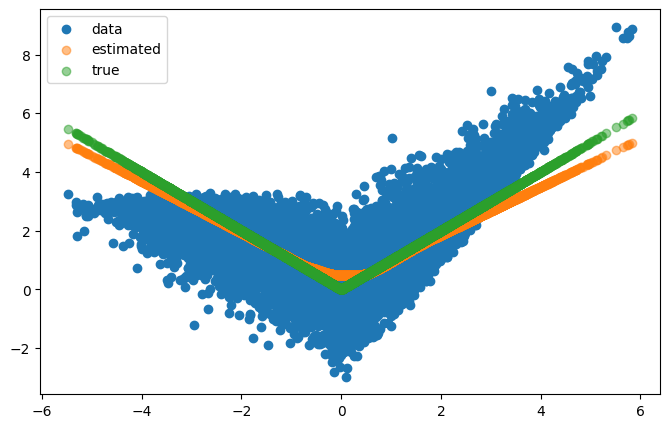

In [15]:
import matplotlib.pyplot as plt
t_un = np.unique(test_data['t'])
f, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.scatter(test_data["t"], test_data["y"], label="data")
ax.scatter(test_data["t"], y_pred, label="estimated", alpha=0.5)
ax.scatter(t_un, np.abs(t_un), label="true", alpha=0.5)
ax.legend()